# Evaluation
This notebook uses preprocessed data with a pretrained model in `./results/`. Then evaluate the performance based on the returns during backtests

# Import libraries and data

In [1]:
!pip install git+https://github.com/quantopian/pyfolio # reinstall
!pip install PyPortfolioOpt

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-i5qj0bfw
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-i5qj0bfw


In [2]:
## import libraries
# os and system file definitions
import sys
sys.path.append("../FinRL-Library")

import os
if not os.path.exists("./" + 'trained_models'):
    os.makedirs("./" + 'trained_models')
if not os.path.exists("./" + 'tensorboard_log'):
    os.makedirs("./" + 'tensorboard_log')
if not os.path.exists("./" + 'results'):
    os.makedirs("./" + 'results')

# utilities
import pandas as pd
import numpy as np
from datetime import datetime as dt
import calendar
# plotting
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import plotly
import plotly.graph_objs as go
import plotly.express as px
# portfolio and returns specific
import pyfolio
from pyfolio import timeseries
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

# TensorBoard notebook extension
import tensorflow as tf
%load_ext tensorboard

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning:

Module "zipline.assets" not found; multipliers will not be applied to position notionals.



# Load trading data and functions

In [3]:
# fxn to predict returns for 2020-01-01 to 2021-09-01
def convert_daily_return_to_pyfolio_ts(df):
    strategy_ret = df.copy()
    strategy_ret["date"] = pd.to_datetime(strategy_ret["date"])
    strategy_ret.set_index("date", drop=False, inplace=True)
    strategy_ret.index = strategy_ret.index.tz_localize("UTC")
    del strategy_ret["date"]
    ts = pd.Series(strategy_ret["daily_return"].values, index=strategy_ret.index)
    return ts

def get_random_baseline(dataframe, start, end):
  # random agent
  df_ret = dataframe.groupby(['date','tic'])['close'].mean().unstack().pct_change()
  # get random weights
  df_rand = pd.DataFrame(np.random.random(size=(len(df_ret),len(df_ret.columns))), 
                        columns=df_ret.columns,
                        index=df_ret.index)
  df_rand = df_rand.div(df_rand.sum(axis=1),axis=0)

  # get daily returns for random agent
  df_rand_ret = df_rand.mul(df_ret).sum(axis=1)

  # convert daily returns to standard format
  df_rand_ret = pd.DataFrame(df_rand_ret).reset_index()
  df_rand_ret.columns=['date','daily_return']
  df_rand_ret = df_rand_ret.loc[(df_rand_ret.date>=start) & (df_rand_ret.date<=end)]
  # save copy of random agent returns
  df_rand_ret.to_csv('./results/df_rand_returns.csv',index=False)

  returns = convert_daily_return_to_pyfolio_ts(df_rand_ret)
  return returns

def get_drg_baseline(dataframe, start, end):
  # random agent
  df_ret = dataframe.groupby(['date','tic'])['close'].mean().unstack().pct_change()

  # get daily returns for random agent
  df_drg_ret = df_ret.mul(drg_wt).sum(axis=1)

  # convert daily returns to standard format
  df_drg_ret = pd.DataFrame(df_drg_ret).reset_index()
  df_drg_ret.columns=['date','daily_return']
  df_drg_ret = df_drg_ret.loc[(df_drg_ret.date>=start) & (df_drg_ret.date<=end)]
  returns = convert_daily_return_to_pyfolio_ts(df_drg_ret)
  # save copy of random agent returns
  df_drg_ret.to_csv('./results/df_drg_returns.csv',index=False)
  return returns


# initialise dragon portfolio weights
drg_wt = [.095,.19,.05, .095,.19,.095,.19,.095]

### Pre Trained models

In [4]:
# URL to git repo
url_df = 'https://github.com/changjulian17/DataSciencePortfolio/blob/main/Investment_Portfolio/data/processed_data.pkl?raw=true'
url_ppo4_ret = 'https://raw.githubusercontent.com/changjulian17/DataSciencePortfolio/main/Investment_Portfolio/results/df_daily_return_14_4.csv'
url_ppo5_ret = 'https://raw.githubusercontent.com/changjulian17/DataSciencePortfolio/main/Investment_Portfolio/results/df_daily_return_14_5.csv'
url_ppo4_act = 'https://raw.githubusercontent.com/changjulian17/DataSciencePortfolio/main/Investment_Portfolio/results/df_actions_14_4.csv'
url_ppo5_act = 'https://raw.githubusercontent.com/changjulian17/DataSciencePortfolio/main/Investment_Portfolio/results/df_actions_14_5.csv'
# Read files
df = pd.read_pickle(url_df)
df_ppo4_ret = pd.read_csv(url_ppo4_ret,index_col='Unnamed: 0')
df_ppo5_ret = pd.read_csv(url_ppo5_ret,index_col='Unnamed: 0')
df_ppo4_act = pd.read_csv(url_ppo4_act)
df_ppo5_act = pd.read_csv(url_ppo5_act)
## this notebook will benchmark returns
url_drg_ret = 'https://raw.githubusercontent.com/changjulian17/DataSciencePortfolio/main/Investment_Portfolio/results/df_drg_returns.csv'
url_minv_ret = 'https://raw.githubusercontent.com/changjulian17/DataSciencePortfolio/main/Investment_Portfolio/results/df_minv_returns.csv'
url_rand_ret = 'https://raw.githubusercontent.com/changjulian17/DataSciencePortfolio/main/Investment_Portfolio/results/df_rand_returns.csv'
df_drg_ret = pd.read_csv(url_drg_ret)
df_minv_ret = pd.read_csv(url_minv_ret)
df_rand_ret = pd.read_csv(url_rand_ret)

# Min-Variance Portfolio

In [5]:
unique_trade_date = df_ppo5_ret.date.unique()

In [6]:
#calculate_portfolio_minimum_variance
min_var_val = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
min_var_val.loc[0,unique_trade_date[0]] = initial_capital
# cols = list(df.return_list.iloc[0].columns.drop(['AGG','IEF','CSH','LOV']))
cols = list(df.return_list.iloc[0].columns.drop(['CSH','LOV']))

for i in range(len(unique_trade_date)-1):
    df_temp = df[(df.date==unique_trade_date[i])&(df.tic.isin(cols))].reset_index(drop=True)
    df_temp_next = df[(df.date==unique_trade_date[i+1])&(df.tic.isin(cols))].reset_index(drop=True)
    Sigma = df_temp.return_list[0][cols].cov()
    #min_var_val allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()
    
    #current capital
    cap = min_var_val.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value 
    min_var_val.iloc[0, i+1] = np.dot(current_shares, next_price)

# Create array for computation of strats
min_var_val=min_var_val.T
min_var_val.columns = ['account_value']
df_minv = min_var_val.account_value.pct_change().reset_index().fillna(0)
df_minv.columns = ['date','daily_return']

In [7]:
df_minv.to_csv('./results/df_minv_returns.csv',index=False)

# Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [8]:
# get daily returns as an array for all 4 strategies
DRL_strat =   convert_daily_return_to_pyfolio_ts(df_ppo5_ret)
rand_strat =  get_random_baseline(df, '2020-01-01', '2021-8-31')
drg_strat =   get_drg_baseline(df, '2020-01-01', '2021-8-31')
minv_strat =  convert_daily_return_to_pyfolio_ts(df_minv)



# Make dataframe of stats
dict_strat = {'PPO' : DRL_strat,
              'Random' : rand_strat, 
              'Dragon' : drg_strat,
              'Min Var' : minv_strat}
# initialise pyfolio
perf_func = timeseries.perf_stats
# create dictionary with stats
d_stats = {}
for name, strat in dict_strat.items():
  # get strategy stats
  d_stats[name] = perf_func(returns=strat, 
                            factor_returns=strat, 
                            positions=None, 
                            transactions=None, 
                            turnover_denom="AGB")
df_stats = pd.DataFrame(d_stats)
# convert values of percentage indicators
pct_list = ['Annual return',
             'Cumulative returns',
             'Annual volatility',
             'Max drawdown',
             'Daily value at risk']
for idx in df_stats.index:
  if idx in pct_list:
    df_stats.loc[idx] *= 100

# save table
df_stats.to_csv('./results/df_strat_stats.csv')

## Back Test Statistics

In [9]:
df_stats

,PPO,Random,Dragon,Min Var
Annual return,13.892873,13.338294,11.280672,0.319598
Cumulative returns,24.211245,23.204844,19.499540,0.533231
Annual volatility,11.986726,10.599993,9.921000,6.062487
Sharpe ratio,1.145683,1.234200,1.127115,0.083245
Calmar ratio,1.218961,1.486863,1.021663,0.028715
Stability,0.898308,0.893809,0.879072,0.082113
Max drawdown,-11.397309,-8.970763,-11.041479,-11.129924
Omega ratio,1.263442,1.308535,1.257345,1.019409
Sortino ratio,1.568561,1.866544,1.601140,0.097004
Skew,-1.160605,0.678506,-0.187556,-4.694967



## Back Test Plots

Start date,2020-01-02
End date,2021-08-31
Total months,20
,Backtest
Annual return,13.893%
Cumulative returns,24.211%
Annual volatility,11.987%
Sharpe ratio,1.15
Calmar ratio,1.22
Stability,0.90
Max drawdown,-11.397%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.40,2020-02-19,2020-03-18,2020-05-20,66
1,3.97,2021-02-11,2021-03-08,2021-05-07,62
2,3.55,2020-09-02,2020-09-24,2020-10-12,29
3,2.73,2020-10-12,2020-10-30,2020-11-05,19
4,2.27,2020-01-17,2020-01-31,2020-02-12,19


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



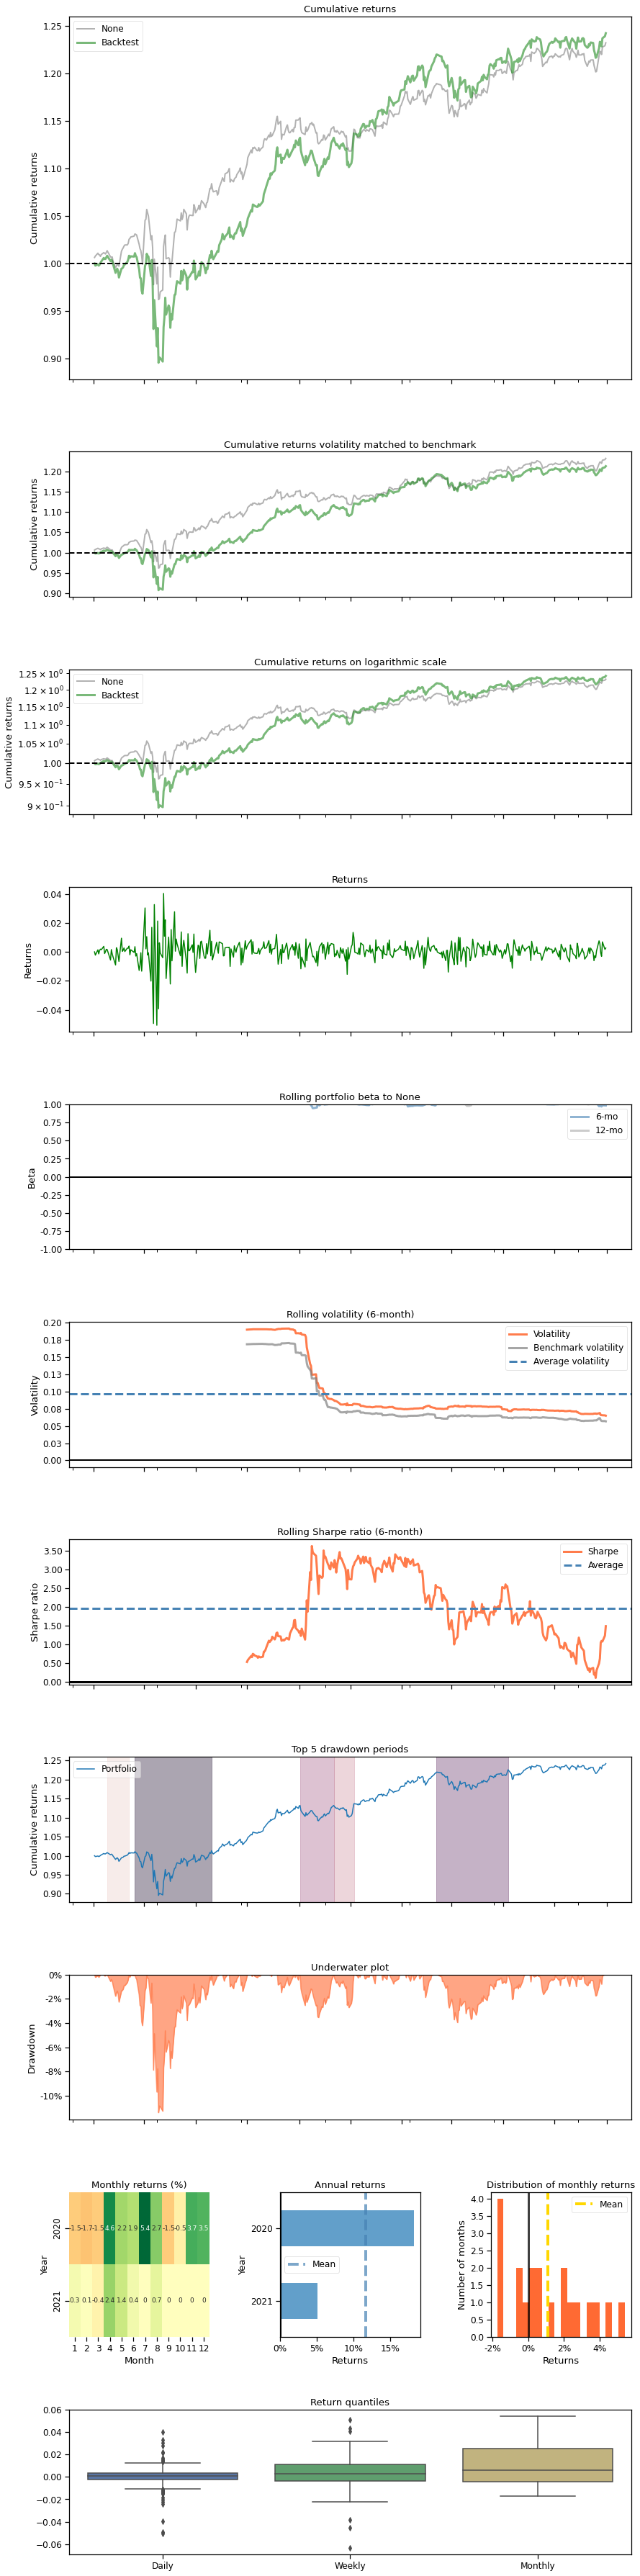

In [10]:
# compare PPO to random portfolio

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=rand_strat,
                                       set_context=False)

Start date,2020-01-02
End date,2021-08-31
Total months,20
,Backtest
Annual return,13.893%
Cumulative returns,24.211%
Annual volatility,11.987%
Sharpe ratio,1.15
Calmar ratio,1.22
Stability,0.90
Max drawdown,-11.397%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.40,2020-02-19,2020-03-18,2020-05-20,66
1,3.97,2021-02-11,2021-03-08,2021-05-07,62
2,3.55,2020-09-02,2020-09-24,2020-10-12,29
3,2.73,2020-10-12,2020-10-30,2020-11-05,19
4,2.27,2020-01-17,2020-01-31,2020-02-12,19


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



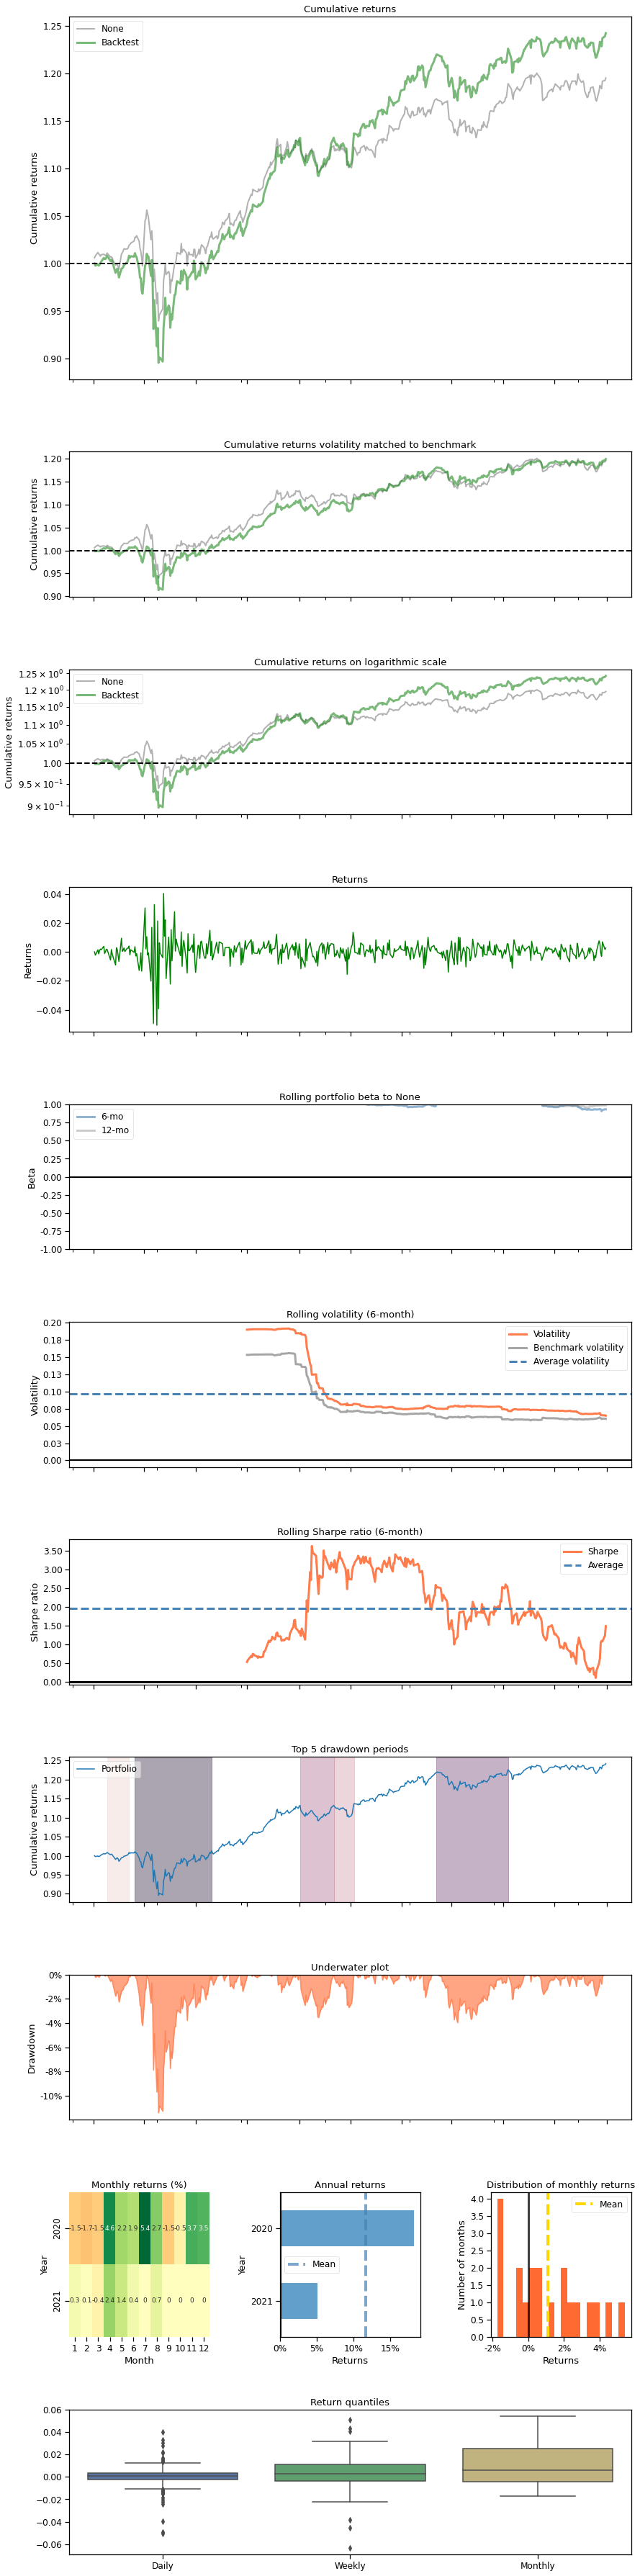

In [11]:
# compare PPO to dragon portfolio

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = convert_daily_return_to_pyfolio_ts(df_ppo5_ret),
                                       benchmark_rets=drg_strat,
                                       set_context=False)

Start date,2020-01-02
End date,2021-08-31
Total months,20
,Backtest
Annual return,13.893%
Cumulative returns,24.211%
Annual volatility,11.987%
Sharpe ratio,1.15
Calmar ratio,1.22
Stability,0.90
Max drawdown,-11.397%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.40,2020-02-19,2020-03-18,2020-05-20,66
1,3.97,2021-02-11,2021-03-08,2021-05-07,62
2,3.55,2020-09-02,2020-09-24,2020-10-12,29
3,2.73,2020-10-12,2020-10-30,2020-11-05,19
4,2.27,2020-01-17,2020-01-31,2020-02-12,19


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning:

Passed returns do not overlap with anyinteresting times.



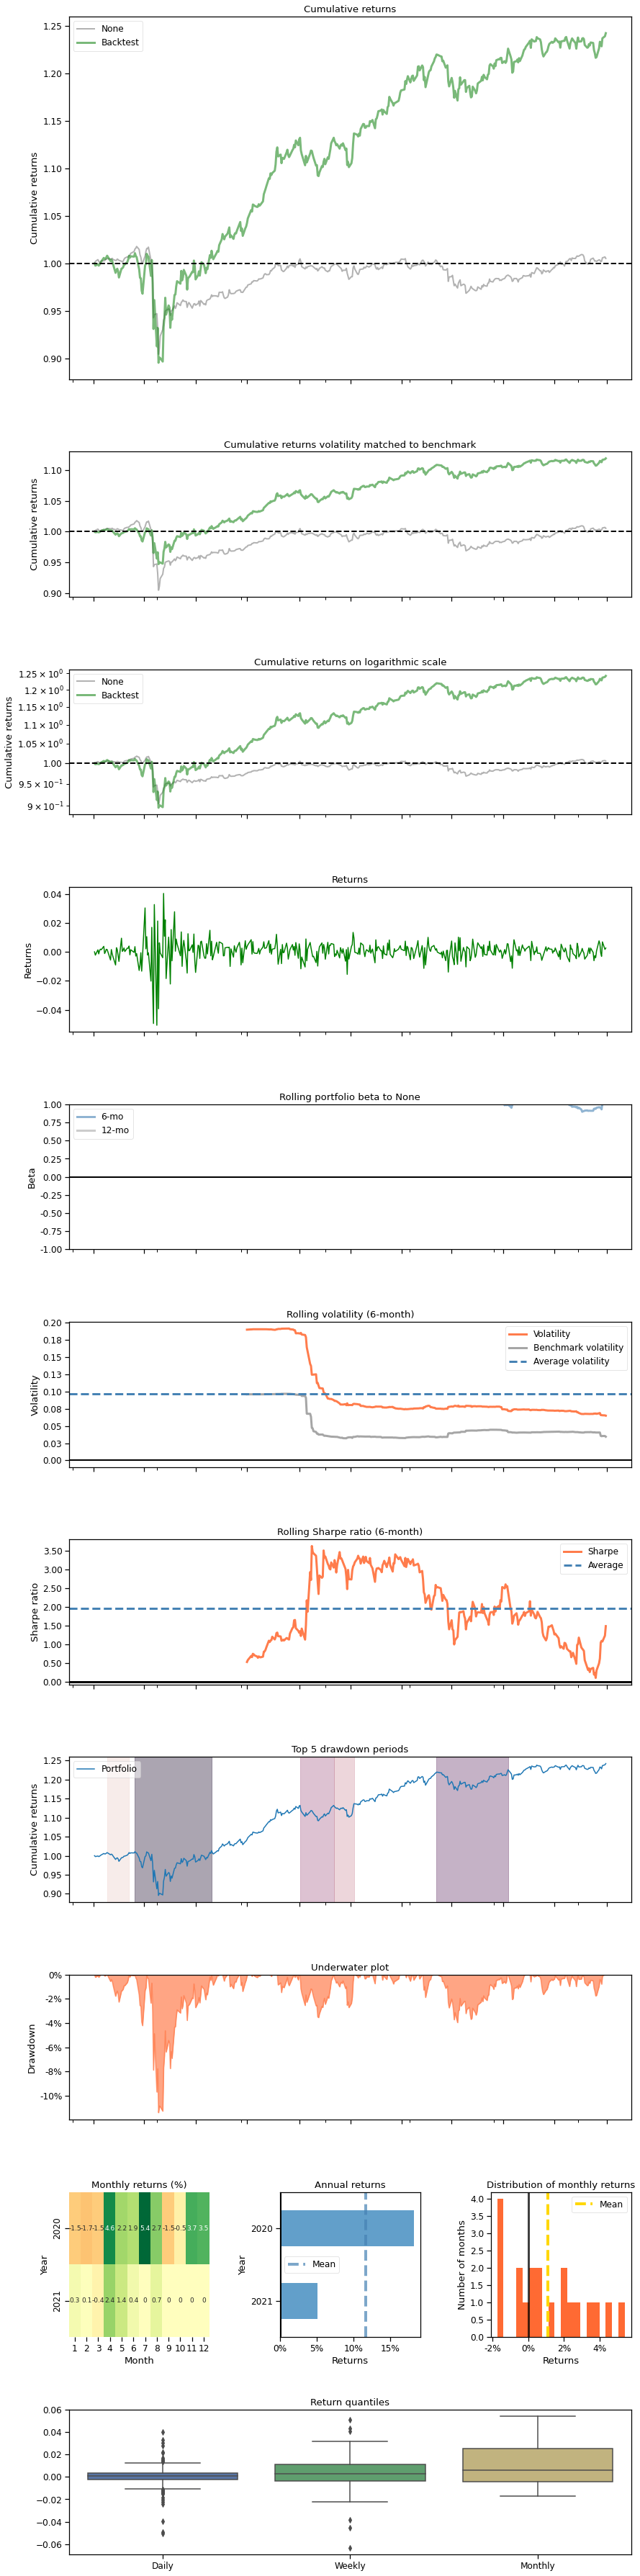

In [12]:
# compare PPO to minimum variance portfolio

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = convert_daily_return_to_pyfolio_ts(df_ppo5_ret),
                                       benchmark_rets=minv_strat,
                                       set_context=False)

# Plotly: DRL, Min-Variance, Dragon

## Compile all 4 portfolio returns

In [13]:
ppo_cumpod =((df_ppo5_ret.daily_return+1).cumprod()-1)*100
drg_cumpod =((df_drg_ret.daily_return+1).cumprod()-1)*100
rdm_cumpod =((df_rand_ret.daily_return+1).cumprod()-1)*100
min_var_cumpod =((df_minv_ret.daily_return+1).cumprod()-1)*100

time_ind = pd.Series(df_ppo4_ret.date)

trace0_portfolio = go.Scatter(x = time_ind, y = ppo_cumpod, mode = 'lines', name = 'PPO (Portfolio Allocation)')
trace1_portfolio = go.Scatter(x = time_ind, y = drg_cumpod, mode = 'lines', name = 'Dragon')
trace2_portfolio = go.Scatter(x = time_ind, y = rdm_cumpod, mode = 'lines', name = 'Random')
trace3_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')

fig = go.Figure()
fig.add_trace(trace0_portfolio)
fig.add_trace(trace1_portfolio)
fig.add_trace(trace2_portfolio)
fig.add_trace(trace3_portfolio)

fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
fig.update_layout(title={
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.update_layout(

    paper_bgcolor='rgba(1, 1, 0, 0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

# Compare PPO 4 and PPO 5 models

In [14]:
ppo_14_4_alloc = df_ppo4_act.set_index('date')*100
# ppo_14_4_alloc = pd.melt(ppo_14_4_alloc.loc['2020-02-25':'2020-04-09'].reset_index(),
ppo_14_4_alloc = pd.melt(ppo_14_4_alloc.reset_index(),
                         id_vars=['date'],
                         var_name='Asset',
                         value_name='Percent Allocated')

fig = px.bar(ppo_14_4_alloc, 
             x="date", 
             color="Asset",
             y='Percent Allocated',
             title="PPO 4 Percent Allocated from 2020-02-25 to 2020-04-09",
             barmode='relative',
             height=600
            )

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    legend=dict(yanchor="top", 
                y=1, 
                xanchor="right", 
                x=1.175,
                orientation= 'v'),
)

# fix y-axis
fig.update_layout(yaxis_range=(0, 100))

fig.show()

In [15]:
ppo_14_5_alloc = df_ppo5_act.set_index('date')*100
ppo_14_5_alloc = pd.melt(ppo_14_5_alloc.reset_index(),
                         id_vars=['date'],
                         var_name='Asset',
                         value_name='Percent Allocated')

fig = px.bar(ppo_14_5_alloc, 
             x="date", 
             color="Asset",
             y='Percent Allocated',
             title="PPO 5 Percent Allocated from 2020-02-25 to 2020-04-09",
             barmode='relative',
             height=600
            )

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    showlegend=False
)

# fix y-axis
fig.update_layout(yaxis_range=(0, 100))

fig.show()

## PPO4 vs PPO 5 timeseries plot

In [16]:
# ppo 4
ppo_cumpod_4 =((df_ppo4_ret.daily_return+1).cumprod()-1)*100

# ppo 5
ppo_cumpod_5 =((df_ppo5_ret.daily_return+1).cumprod()-1)*100
# x-axis
time_ind = pd.Series(df_ppo5_ret.date)

trace4_portfolio = go.Scatter(x = time_ind, y = ppo_cumpod_4, mode = 'lines', name = 'PPO 4')
trace5_portfolio = go.Scatter(x = time_ind, y = ppo_cumpod_5, mode = 'lines', name = 'PPO 5')

fig = go.Figure()
fig.add_trace(trace4_portfolio)

fig.add_trace(trace5_portfolio)



fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)

fig.update_layout(title={
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.update_layout(

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

### portfolio weights

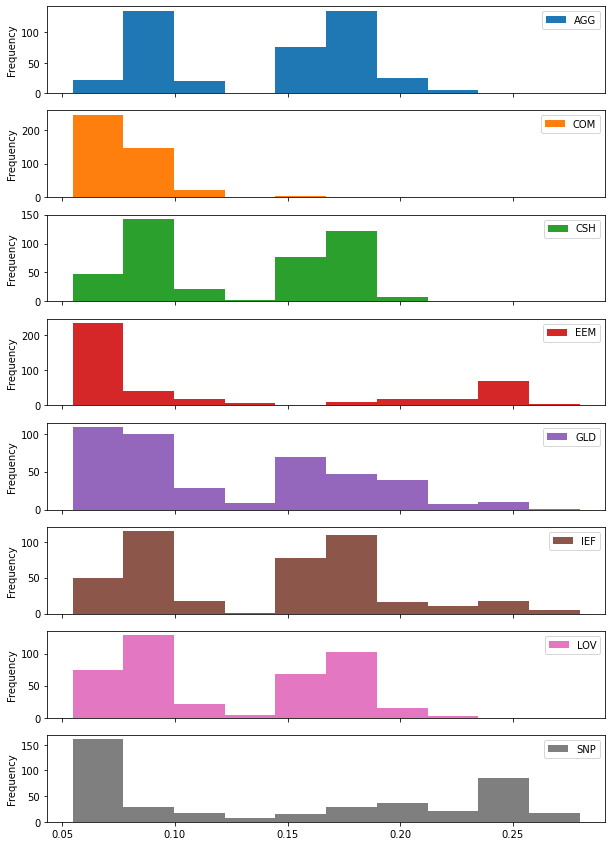

In [17]:
df_ppo4_act[1:].plot(kind='hist',
                      subplots=True,
                      figsize=(10,15));

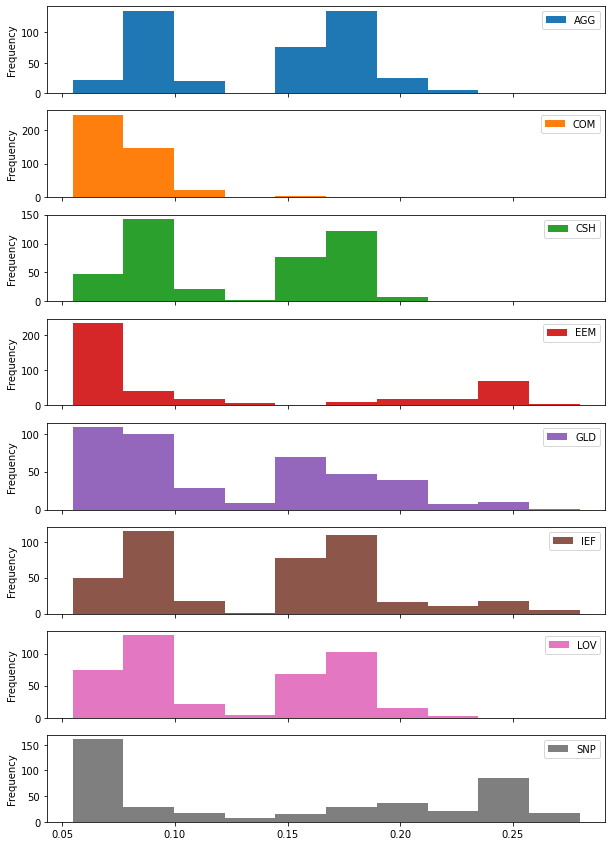

In [18]:
df_ppo4_act[1:].plot(kind='hist',
                      subplots=True,
                      figsize=(10,15));

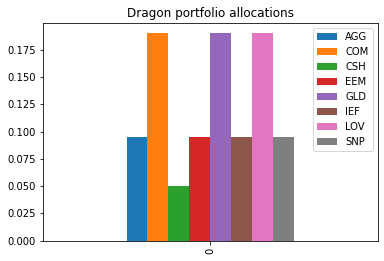

In [19]:
df_drg_wt = pd.DataFrame(drg_wt).T
df_drg_wt.columns = df_ppo4_act.columns.drop('date')
df_drg_wt.plot(kind='bar')
plt.title('Dragon portfolio allocations');

### Distribution of earnings

In [21]:
d_rets = {'ppo_4' : convert_daily_return_to_pyfolio_ts(df_ppo4_ret),
          'ppo_5' : convert_daily_return_to_pyfolio_ts(df_ppo5_ret),
          'random' : rand_strat,
          'dragon' : drg_strat,
          'min_var': minv_strat,
}
df_rets = pd.DataFrame(d_rets)*100
df_rets_melt = pd.melt(df_rets.reset_index(),
                  id_vars=['date'],
                  var_name='portfolio',
                  value_name='Percent Return')

fig = px.histogram(df_rets_melt, 
                    x="Percent Return", 
                    color="portfolio",
                    title="Percent return by portfolio",
                    barmode='group',
                    height=600,
                  #  facet_col='portfolio'
                    )

fig.update_layout(yaxis_range=(0, 90))

fig.show()

# Tensorboard

In [22]:
# %tensorboard --logdir /content/tensorboard_log/ppo
print('To see my Tensorboard results go to \n\
        https://tensorboard.dev/experiment/z20zIbr6TmSQ3vqUBTpkAw/#scalars')

To see my Tensorboard results go to 
        https://tensorboard.dev/experiment/z20zIbr6TmSQ3vqUBTpkAw/#scalars
